In [2]:
import numpy as np
from scipy.stats import spearmanr
from scipy import sparse
import cmath
from sklearn.decomposition import PCA
import sys, os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm
import matplotlib.patches as patches




sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')
from futils import read_metrics_filepath, extract_weights, data2percentile, get_hilbert, get_phases, get_synch, jthreshold
from futils import ensemble_detection

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

In [3]:
FISH_ID = 5
#data_filepath = '../data/fish-%d-processed-2.npz' % FISH_ID
data_filepath = '../data/fish%d-RNN-baseline-data.npz' % FISH_ID
f = np.load(data_filepath)
baseline_traces = f['traces']
baseline_traces = f['traces'][:,::2]
coords          = f['spatial']
S               = f['S']
f.close()

data_filepath = '../data/fish%d-RNN-presz-data.npz' % FISH_ID
#data_filepath = '../data/fish-perturbation/f%d/edge-swap/bifan/fish-5-bifanswap-1.npz' % FISH_ID
f = np.load(data_filepath)
presz_traces = f['traces']
presz_traces = f['traces'][:,::2]
f.close()

traces = np.concatenate((baseline_traces.T, presz_traces.T)).T
print(traces.shape, baseline_traces.shape, presz_traces.shape)
complete_times = np.arange(0, traces.shape[1]) * 0.5
dynamic_times  = complete_times[120:]

presz_start_idx = 500
sz_start_idx = 2190
#fish 2 - 1370
#fish 3 - 1270
#fish 5 - 2190
#fish 6 - 1360

from modeling_analysis_utils import load_neurons
traces_full_filepath         = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID
mask_filepath                = '../data/f090518-%iZbrain_IDs.npz' % FISH_ID

###
_, all_spatial_coords        = load_neurons(mask_filepath, region_name=['Telencephalon -', 
                                                                         'Mesencephalon -', 
                                                                         'Diencephalon -', 
                                                                         'Rhombencephalon -',], extend=True)
all_spatial_coords = np.asarray(all_spatial_coords, dtype='float32')

_, dthalamus_spatial_coords  = load_neurons(mask_filepath, region_name='Diencephalon - Dorsal Thalamus')
_, vthalamus_spatial_coords = load_neurons(mask_filepath, region_name='Diencephalon - Ventral Thalamus')

_, cerebellum_spatial_coords = load_neurons(mask_filepath, region_name='Rhombencephalon - Cerebellum')
_, hypothalamus_spatial_coords   = load_neurons(mask_filepath, region_name='Diencephalon - Intermediate Hypothalamus')
                                                                        
_, preoptic_spatial_coords  = load_neurons(mask_filepath,region_name='Diencephalon - Preoptic Area')
_, tectum_spatial_coords    = load_neurons(mask_filepath, region_name='Mesencephalon - Tectum Stratum Periventriculare')
_, habenula_spatial_coords = load_neurons(mask_filepath, region_name='Diencephalon - Habenula')


(4836, 2020) (4836, 480) (4836, 1540)


(-23.950000000000003, 502.95, -1.8323066055774688, 3.62772713303566)

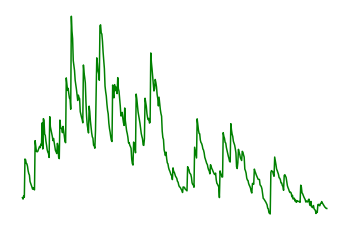

In [1428]:
plt.figure()
plt.plot(baseline_traces[50,:], color='g')
plt.axis('off')

In [4]:
min_nonzero  = np.min(S[S > 0])
S = np.log10(S + min_nonzero)
maxS, minS = np.max(S), np.min(S)
S    = ((S - minS) / (maxS - minS))
S += min_nonzero

0
100
200
300


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


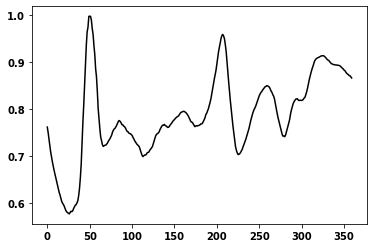

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


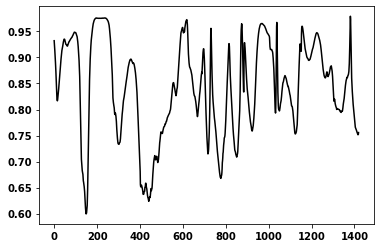

In [5]:
## Extract graph metrics


def get_metrics(metrics_filepath, nmatrices):
    dynamic_degree_centrality, dynamic_eigenvector_centrality, dynamic_clustering_coefficient = read_metrics_filepath(metrics_filepath, nmatrices, [], verbose=True)
    dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality_percentile, dynamic_cc_percentile  = [], [], []
    method = 'average'

    for i in range(len(dynamic_degree_centrality)):
        dynamic_degree_centrality_percentile.append(data2percentile(dynamic_degree_centrality[i], method=method))
        dynamic_eigenvector_centrality_percentile.append(data2percentile(dynamic_eigenvector_centrality[i], method=method))
        dynamic_cc_percentile.append(data2percentile(dynamic_clustering_coefficient[i], method=method))
    dynamic_degree_centrality_percentile      = np.asarray(dynamic_degree_centrality_percentile, dtype='float32')
    dynamic_eigenvector_centrality_percentile = np.asarray(dynamic_eigenvector_centrality_percentile, dtype='float32')
    dynamic_cc_percentile = np.asarray(dynamic_cc_percentile, dtype='float32')

    dynamic_ev_deg_correlation = []
    for i in range(len(dynamic_degree_centrality_percentile)):
        deg = dynamic_degree_centrality_percentile[i]
        ev  = dynamic_eigenvector_centrality_percentile[i]

        rho, _ = spearmanr(deg, ev)
        dynamic_ev_deg_correlation.append(rho)
        
    plt.figure()
    plt.plot(dynamic_ev_deg_correlation, color='k')
    plt.show()
        
    return dynamic_degree_centrality, dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality, dynamic_eigenvector_centrality_percentile, dynamic_ev_deg_correlation
    

metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f5-perturbation/baseline/graph-metrics'
baseline_degree_centrality, baseline_degree_percentile, baseline_ev_centrality, baseline_ev_percentile, baseline_ev_deg_corr = get_metrics(metrics_filepath, 
                                                                                                                     360)

metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f5-perturbation/presz/graph-metrics'
#metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f5-perturbation/edge-swap/bifan/f1/graph-metrics'

# f2 360/600 -- 839/1319
# f3 360/500 -- 839/1119
# f5 360/1420 -- 839 / 2959 
presz_degree_centrality, presz_degree_percentile, presz_ev_centrality, presz_ev_percentile, presz_ev_deg_corr = get_metrics(metrics_filepath, 
                                                                                                         1420)

combined_degree_centrality = np.concatenate((baseline_degree_centrality, presz_degree_centrality))
combined_degree_percentile = np.concatenate((baseline_degree_percentile, presz_degree_percentile))
combined_ev_percentile     = np.concatenate((baseline_ev_percentile, presz_ev_percentile))


Using matplotlib backend: Qt5Agg


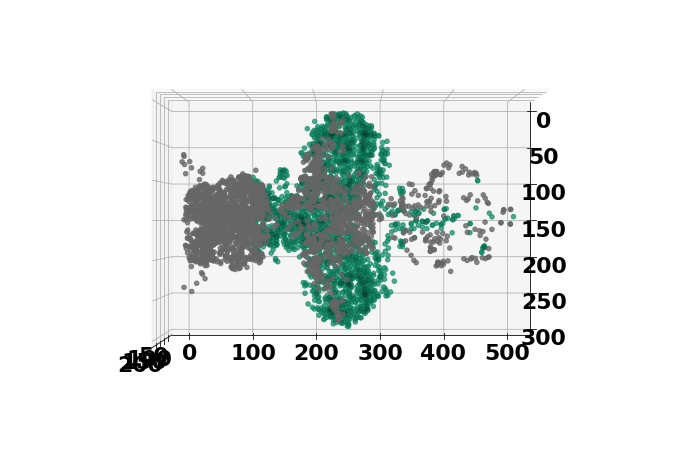

In [228]:
from copy import deepcopy
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform


#Z = sch.linkage(S, method='ward', metric='euclidean')
#inds   = sch.fcluster(Z, 2, 'maxclust')

%matplotlib auto
import matplotlib.cm as cm
colors = cm.Dark2(np.linspace(0,1,len(set(inds))))

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter(*coords.T, color='k', alpha=0.05)

for (i, ind) in enumerate(set(inds)):
    ax.scatter(*coords[np.where(inds==ind)[0],:].T, color=colors[i], alpha=0.75)
   
# ax.scatter(*coords[np.where(inds==1)[0],:].T, color='r', alpha=0.25)
# ax.scatter(*coords[np.where(inds==2)[0],:].T, color='b', alpha=0.25)
#ax.scatter(*coords[np.where(inds==3)[0],:].T, color='g')
#ax.scatter(*coords[np.where(inds==4)[0],:].T, color='m')

ax.view_init(90,0)
plt.show()

In [6]:

#f2

# thalamus_idxs = [1751,1906,1911,1914,1944,1945,1946,1947,1948,1949,1950,1951,1953,1954,1956,1959,1968,1978,2024,2032,2034,2038,2039,2041,2046,2056,2064,2067,2069,2070,2079,2084,2085,2125,2187,2188,2191,2196,2200,2201,2205,2208,2214,2215,2246,2252,2257,2300,2303,2419,3943,3984,4063,4064,4066,4072,4074,4075,4077,4079,4081,4084,4090,4092,4096,4098,4099,4100,4101,4104,4106,4107,4108,4109,4110,4111,4112,4113,4115,4116,4117,4118,4119,4125,4126,4127,4131,4132,4133,4134,4141,4144,4148,4149,4156,4159,4162,4164,4165,4172,4178,4180,4181,4183,4184,4185,4187]
# tectum_idxs   = [221,234,237,241,246,251,263,264,267,269,274,275,276,283,289,293,300,302,307,318,319,324,325,332,334,335,336,337,339,359,360,364,368,394,395,420,421,422,424,428,437,439,443,448,459,461,465,467,477,480,482,491,494,497,500,504,505,507,508,509,512,513,518,519,523,1143,1163,1191,1223,1229,1232,1263,1266,1272,1309,2317,2375,2391,2392,2888,2890,2893,2926,2938,2944,2960,2961,2975,2976,2982,2992,3035,3037,3040,3056,3059,3062,3082,3086,3088,3095,3104,3108,3116,3126,3128,3171,3183,3184,3190,3200,3203,3204,3210,3212,3218,3225,3226,3239,3243,3245,3348,3355,3359,3378,3387,3391,3393,3401,3407,3411,3420,3423,3428,3429,3434,3436,3437,3438,3461,3481,3491,3518,3520,3533,3537,3556,3563,3584,3588,3589,3595,3604,3605,3627,3629,3630,3634,3637,3639,3665,3666,3680,3681,3690,3691,3707,3718,3725,3743,3748,3751,3755,3758,3777,3779,3949,3968,3971,3979]
# telen_idxs    = [547,557,563,1353,1364,1387,1391,1437,1438,1448,1504,1517,1518,1525,1528,1531,1533,1538,1550,1552,1554,1559,1561,1562,1563,1569,1574,1588,1590,1592,1594,1605,1606,1609,1614,1637,1649,1650,1654,1664,1683,1684,1685,1687,1688,1710,1717,1718,1720,1731,1740,1742,1744,1745,1756,1760,1768,1769,1770,1795,1798,1800,1819,1821,1828,1831,2030,2089,2091,2093,2094,2095,2096,2098,2106,2107,2109,2113,2114,2115,2116,2118,2120,2123,2126,2131,2132,2134,2135,2138,2139,2140,2141,2142,2143,2145,2161,2175,2177,2178,2184,2218,2225,2227,2230,2232,2234,2236,2239,2240,2247,2255,2256,2259,2260,2264,2265,2266,2269,2270,2272,2281,2284,2340,2346,2371,2412,2521,2523,2526,2530,2536,2538,2543,2546,2559,2588,2593,2596,2603,2617,2621,2623,2624,2626,2631,2636,2637,2639,2642,2643,2650,2658,2682,2683,2686,2713,2715,2718,2725,2766,2767,2770,2777,2827,2843,2849,2861,2862,2869,2877,4093,4151,4155]


#f3 80th

# thalamus_idxs  = [328,1175,1177,1196,1209,1211,1218,1220,1222,1223,1228,1236,1241,1262,1267,1269,1270,1281,1286,1288,1296,1299,1302,1311,1314,1318,1334,1338,1344,1345,1349,1350,1351,1354,1356,1357,1363,1383,1384,1385,1390,1398,1537,1570,1571,1575,1578,1581,1623,1647,1658,1660,1662,1665,1674,1675,1677,1688,1695,1701,1702,1709,1731,1738,1741,1745,1746,1750,1751,1754,1755,1756,1760,1767,1787,1789,1795,1804,1815,1816,1820,1823,1844,1854,1951,2014,2016,2021,2036,2039,2050,2063,2120,2165,2233,2252,2255,2266,2276,2330,2366,2381,2402,2429,2799,2882,2908,2915,2916,2951,2952,3311,3315,3325,3329,3333,3335,3337,3343,3344,3347,3351,3352,3353,3363,3364,3366,3371,3376,3378,3379,3382,3386,3387,3388,3390,3396]
# tectum_idxs    = [214,242,248,252,253,257,264,285,286,287,289,940,960,978,979,988,999,1826,1828,1863,2441,2444,2445,2448,2452,2454,2455,2457,2460,2461,2462,2463,2465,2466,2468,2469,2470,2473,2474,2477,2478,2480,2481,2483,2488,2489,2492,2496,2497,2499,2501,2504,2505,2506,2508,2509,2514,2517,2528,2531,2532,2538,2539,2557,2561,2588,2595,2597,2598,2601,2602,2603,2620,2628,2646,2780,2782,2788,2790,2792,2793,2796,2802,2803,2804,2805,2810,2811,2814,2816,2817,2819,2820,2821,2827,2828,2829,2831,2833,2840,2843,2845,2846,2847,2851,2854,2856,2859,2867,2873,2877,2880,2881,2929,2930,2999,3002,3043,3046,3050,3055,3056,3058,3062,3063,3064,3066,3076,3079,3087,3088,3089,3090,3093,3101,3105,3106,3109,3113,3117,3120,3121,3122,3126,3134,3137,3139,3146,3235,3253,3265,3272,3274,3307,3397,3487,3488,3489,3494,3496,3500,3503,3504,3513,3514,3521,3528,3537,3548,3555]
# telen_idxs     = [323,1012,1013,1014,1016,1017,1018,1021,1024,1031,1033,1040,1043,1053,1058,1059,1060,1064,1070,1071,1072,1073,1074,1076,1078,1080,1100,1106,1115,1116,1117,1120,1192,1193,1195,1204,1205,1207,1210,1217,1243,1244,1256,1257,1268,1271,1275,1278,1280,1287,1312,1317,1322,1324,1327,1366,1373,1382,1392,1394,1395,1405,1406,1479,1485,1527,1532,1535,1580,1582,1584,1589,1646,1663,1667,1668,1669,1671,1672,1678,1680,1681,1682,1684,1689,1690,1691,1692,1696,1697,1699,1704,1706,1707,1708,1710,1711,1713,1718,1720,1722,1723,1725,1728,1732,1733,1734,1739,1740,1742,1747,1748,1757,1764,1765,1766,1768,1770,1775,1777,1778,1779,1780,1782,1791,1796,1798,1800,1802,1807,1808,1809,1812,1813,1814,1819,1824,1869,1877,1881,1905,1944,2011,2015,2022,2024,2026,2027,2029,2030,2032,2033,2034,2038,2043,2044,2052,2053,2054,2056,2058,2060,2061,2064,2065,2069,2072,2074,2080,2081,2082,2083,2085,2089,2097,2098,2099,2102,2103,2104,2106,2107,2108,2109,2110,2112,2113,2114,2115,2122,2123,2124,2128,2129,2131,2132,2133,2136,2139,2140,2146,2148,2151,2152,2153,2158,2160,2172,2177,2178,2180,2182,2196,2201,2204,2205,2207,2209,2210,2211,2215,2220,2223,2226,2227,2234,2235,2237,2240,2241,2242,2244,2245,2246,2248,2253,2258,2259,2262,2267,2268,2269,2281,2287,2289,2290,2291,2293,2295,2296,2298,2299,2300,2301,2302,2306,2307,2309,2310,2312,2313,2314,2318,2321,2322,2323,2324,2329,2332,2337,2339,2341,2343,2344,2348,2350,2355,2356,2357,2360,2361,2362,2364,2365,2369,2370,2371,2377,2378,2379,2383,2386,2388,2389,2391,2404,2409,2413,2414,2415,2420,2421,2422,2423,2425,3331,3354,3381,3389]


# f5

thalamus_idxs = [2001,2033,2036,2080,2081,2082,2090,2100,2102,2105,2106,2107,2113,2124,2126,2127,2131,2132,2133,2136,2138,2139,2149,2179,2183,2185,2186,2187,2188,2192,2193,2195,2196,2197,2198,2202,2203,2204,2207,2209,2211,2212,2213,2214,2215,2216,2219,2221,2223,2232,2233,2234,2237,2238,2239,2244,2451,2454,2459,2471,2472,2499,2512,2710,4367,4373,4374,4388,4393,4396,4397,4402,4403,4406,4408,4411,4413,4414,4415,4417,4421,4422,4423,4447,4449,4456,4463,4471,4474,4477,4479,4488,4489,4491,4492,4493,4504,4507,4508]
tectum_idxs   = [96,189,190,196,230,232,233,235,246,258,260,265,274,298,343,366,370,380,381,382,398,404,416,419,420,421,423,427,439,658,662,664,840,844,845,851,900,1065,1070,1078,1099,1111,1115,1120,1189,1196,1204,1227,1229,1232,1234,1238,1239,1242,1258,1259,1270,1935,1978,2245,2247,2250,2251,2326,2333,2337,2339,2340,2372,2374,2384,2428,2443,2977,2986,3016,3017,3019,3020,3021,3024,3033,3039,3041,3043,3044,3045,3051,3052,3053,3055,3067,3068,3069,3077,3081,3082,3099,3101,3102,3106,3111,3113,3114,3123,3136,3139,3146,3147,3152,3155,3162,3168,3170,3171,3172,3173,3175,3176,3177,3181,3187,3188,3192,3196,3197,3199,3201,3206,3216,3225,3226,3229,3231,3232,3235,3240,3245,3250,3251,3253,3254,3255,3261,3262,3270,3273,3280,3281,3290,3295,3299,3301,3302,3305,3311,3320,3324,3325,3326,3332,3349,3353,3354,3365,3368,3370,3378,3393,3396,3402,3437,3438,3439,3440,3452,3487,3568,3609,3612,3613,3645,3650,3658,3660,3661,3663,3667,3668,3669,3670,3681,3686,3690,3693,3694,3697,3700,3702,3704,3708,3713,3718,3728,3729,3736,3737,3743,3748,3749,3751,3755,3759,3763,3765,3768,3769,3771,3777,3781,3783,3786,3787,3792,3797,3801,3803,3805,3807,3812,3816,3818,3833,3842,3845,3849,3851,3852,3854,3856,3859,3860,3864,3865,3882,3887,3891,3902,3903,3904,3907,3908,3928,3932,3935,3944,3945,3949,3951,3969,3970,3974,3997,4001,4003,4008,4011,4019,4022,4029,4035,4037,4039,4048,4049,4059,4060,4064,4075,4076,4090,4092,4093,4170,4172,4221,4271,4429,4576,4587,4612,4614,4629,4655,4658,4676,4698,4730,4745,4770]
telen_idxs    = [511,523,1439,1440,1443,1445,1475,1482,1487,1491,1492,1493,1496,1497,1500,1505,1507,1510,1514,1515,1520,1523,1538,1544,1551,1554,1555,1558,1565,1567,1573,1578,1580,1590,1608,1619,1623,1626,1631,1650,1652,1658,1664,1679,1684,1686,1694,1701,1702,1706,1710,1715,1719,1721,1722,1735,1746,1754,1755,1756,1758,1759,1760,1763,1771,1785,1786,1789,1791,1794,1800,1802,1806,1808,1831,1835,1842,1846,1850,1852,1862,1864,1867,1870,1882,1886,1890,1899,1900,1908,2006,2007,2043,2056,2069,2072,2073,2074,2076,2104,2141,2142,2153,2165,2166,2171,2172,2173,2174,2363,2388,2390,2402,2518,2523,2529,2531,2532,2537,2538,2540,2543,2544,2550,2566,2568,2580,2586,2593,2596,2601,2609,2615,2616,2620,2622,2624,2632,2639,2642,2644,2645,2646,2648,2651,2663,2666,2667,2671,2675,2680,2681,2688,2726,2730,2748,2755,2760,2764,2767,2778,2786,2800,2804,2826,2831,2832,2835,2851,2854,2860,2866,2867,2869,2875,2879,2882,2889,2891,2924,4364,4370,4428,4497] 




In [7]:
def build_raster(dp, ep, cut=0.80):
    raster = []
    for i in range(len(dp)):
        d, e = dp[i], ep[i]
        hubs = np.where((d>cut))[0]
        shubs = np.where((e>cut) & (d>cut))[0] 
    
        sl = np.zeros(len(d), dtype='uint8')
        sl[shubs] = 1
        raster.append(sl)
    return np.asarray(raster, dtype='uint8')

baseline_raster = build_raster(baseline_degree_percentile, baseline_ev_percentile, cut=0.80)
presz_raster    = build_raster(presz_degree_percentile, presz_ev_percentile, cut=0.80)
combined_raster = np.concatenate((baseline_raster, presz_raster))
print(combined_raster.shape)

(1780, 4836)


Using matplotlib backend: Qt5Agg
4836


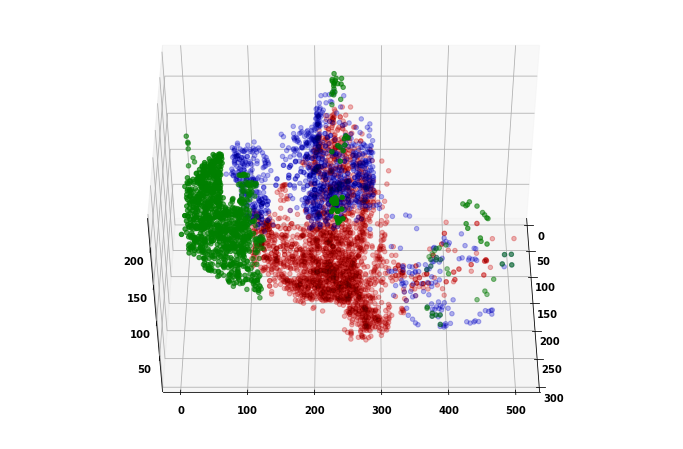

In [1175]:
from copy import deepcopy
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

Z = sch.linkage(S, method='ward', metric='euclidean')
inds   = sch.fcluster(Z, 3, 'maxclust')

%matplotlib auto
import matplotlib.cm as cm

colors = cm.Dark2(np.linspace(0,1,8))

fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
print(len(inds))
ax.scatter(*coords.T, color='k', alpha=0.05)
#for (i, ind) in enumerate(set(inds)):
ax.scatter(*coords[np.where(inds==1)[0],:].T, color='r', alpha=0.25)
ax.scatter(*coords[np.where(inds==2)[0],:].T, color='b', alpha=0.25)
ax.scatter(*coords[np.where(inds==3)[0],:].T, color='g')
#ax.scatter(*coords[np.where(inds==4)[0],:].T, color='m')
#ax.scatter(*dthalamus_spatial_coords.T, color='g')
#ax.scatter(*vthalamus_spatial_coords.T, color='g')

ax.view_init(45,0)
plt.show()

emean cutoff: 0.502
[2179, 4488, 4489, 2187, 4491, 4367, 2195, 2196, 2197, 4373, 4374, 2451, 2202, 4507, 2204, 2207, 2080, 4388, 2213, 2215, 2216, 4393, 2472, 2219, 4396, 4397, 2102, 4406, 2232, 2105, 2106, 4408, 4411, 2237, 4414, 2239, 4415, 2113, 4417, 2244, 4421, 4423, 2124, 2126, 2127, 2001, 2131, 2132, 2133, 2138, 4447, 4449, 2149, 4456, 4463, 2033, 2036, 4474, 4477]
61 59 53
99
---
86
184
----
114
300
---


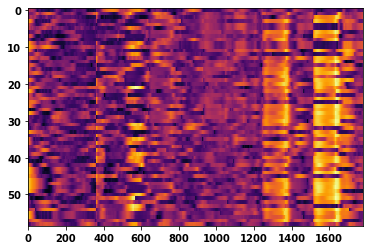

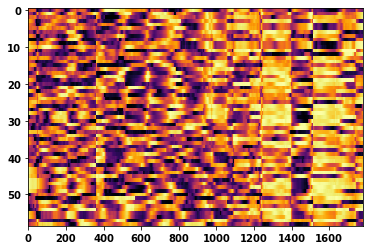

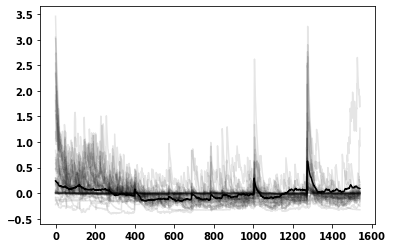

In [9]:

baseline_ev_ranked = []
for ev in baseline_ev_centrality:
    from scipy.stats import rankdata
    baseline_ev_ranked.append(rankdata(ev))
baseline_ev_ranked = np.asarray(baseline_ev_ranked)

presz_ev_ranked = []
for ev in presz_ev_centrality:
    from scipy.stats import rankdata
    presz_ev_ranked.append(rankdata(ev))
presz_ev_ranked = np.asarray(presz_ev_ranked)

dbaseline, ebaseline = np.mean(baseline_degree_centrality[:,:], axis=0), np.median(baseline_ev_ranked[:, :], axis=0)
dpresz, epresz       = np.mean(presz_degree_centrality[:,:], axis=0), np.median(presz_ev_percentile[:,:], axis=0)

baseline_degree_p = data2percentile(ebaseline)
presz_degree_p    = data2percentile(epresz)
jump = (presz_degree_p - baseline_degree_p)
top_jumps = np.where(jump > np.percentile(jump, 90))[0]


emean_cutoff    = np.percentile(epresz, 50.)
print('emean cutoff: %0.3f' % emean_cutoff)
etemporal_idxs = np.where(epresz > emean_cutoff)[0]

dmean_cutoff = np.percentile(dpresz, 50.)
dtemporal_idxs = np.where(dpresz > dmean_cutoff)[0]


eth_jump_overlap = list(set(etemporal_idxs) & set(thalamus_idxs))
print(eth_jump_overlap)
dth_jump_overlap = list(set(dtemporal_idxs) & set(thalamus_idxs))
th_jump_overlap  = list(set(dth_jump_overlap) & set(eth_jump_overlap))
print(len(dth_jump_overlap), len(eth_jump_overlap), len( set(dth_jump_overlap) & set(eth_jump_overlap) ) )
print(len(thalamus_idxs))
print('---')

etel_jump_overlap = list(set(etemporal_idxs) & set(list(telen_idxs)) )
print(len (etel_jump_overlap) )
print(len(telen_idxs))
print('----')

etect_jump_overlap = list(set(etemporal_idxs) & set(list(tectum_idxs)) )
print(len (etect_jump_overlap) )
print(len(tectum_idxs))
print('---')


plt.figure()
plt.imshow(combined_degree_centrality[:,eth_jump_overlap].T, cmap='inferno', aspect='auto')
plt.show()

plt.figure()
plt.imshow(combined_ev_percentile[:,eth_jump_overlap].T, cmap='inferno', aspect='auto')
plt.show()

plt.figure()
plt.plot(presz_traces[th_jump_overlap,:].T, color='k', alpha=0.1)
plt.plot(np.mean(presz_traces,axis=0), color='k')
plt.show()

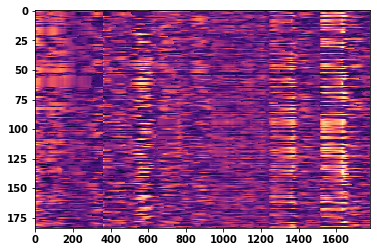

(1780, 4836) (4836, 2020)


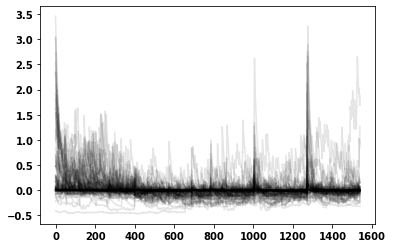

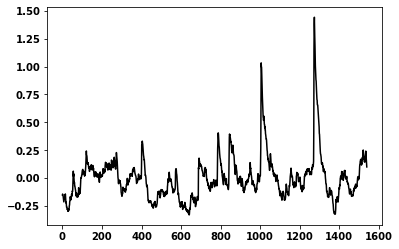

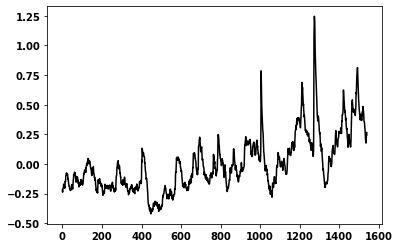

In [1389]:
%matplotlib inline

idxs= telen_idxs

T = traces.shape[1]
times = np.arange(0,T)
fig, ax = plt.subplots()
ax.imshow(combined_degree_centrality[:,idxs].T, cmap='magma', aspect='auto')
#ax2 = ax.twinx()
#ax2.plot(np.mean(traces[idxs,::2],axis=0), color='g', linewidth=2)
plt.show()
print(combined_degree_centrality.shape, traces.shape)

plt.figure()
plt.plot(traces[thalamus_idxs, baseline_traces.shape[1]:].T, color='k', alpha=0.1)
plt.show()
plt.figure()
plt.plot(traces[telen_idxs, baseline_traces.shape[1]:].mean(axis=0), color='k')
plt.show()
plt.figure()
plt.plot(traces[tectum_idxs, baseline_traces.shape[1]:].mean(axis=0), color='k')
plt.show()



# plt.figure()
# plt.imshow(combined_ev_percentile[:,idxs].T, cmap='inferno', aspect='auto', vmin=0., vmax=1.)
# plt.show()
# print(baseline_traces.shape)

# start = baseline_traces.shape[1] + 120
# tstart = int(start/4)
# times = np.arange(0,traces.shape[1]/4 - tstart - 0.5,0.5)
# fig, ax = plt.subplots(3,1)
# ax[0].set_xticks([])
# ax[0].plot(times,traces[thalamus_idxs[0:20],start::2].T, color='c', alpha=0.15)
# ax0 = ax[0].twinx()
# ax0.plot(times,np.mean(traces[thalamus_idxs,start::2],axis=0), color='k', alpha=1.0, linewidth=1.5)
# ax0.set_yticks([])

# ax[1].plot(times,traces[telen_idxs[0:20],start::2].T, color='r', alpha=0.15)
# ax[1].set_xticks([])
# ax1 = ax[1].twinx()
# ax1.plot(times, np.mean(traces[telen_idxs,start::2],axis=0), color='k', alpha=1.0, linewidth=1.5)
# ax1.set_yticks([])

# ax[2].plot(times, traces[tectum_idxs[0:20],start::2].T, color='g', alpha=0.15)
# ax[2].set_xticks([])
# ax2 = ax[2].twinx()
# ax2.plot(times, np.mean(traces[tectum_idxs,start::2],axis=0), color='k', alpha=1.0, linewidth=1.5)

# ax[3].plot(times,np.mean(traces[:,start::2],axis=0), color='k')
# ax[3].plot(times,np.mean(traces[thalamus_idxs,start::2],axis=0), color='c')
# ax[3].plot(times,np.mean(traces[tectum_idxs,start::2],axis=0), color='g')
# ax3 = ax[3].twinx()
# ax3.plot(times,np.mean(traces[telen_idxs,start::2],axis=0), color='r')
# ax3.set_yticks([])


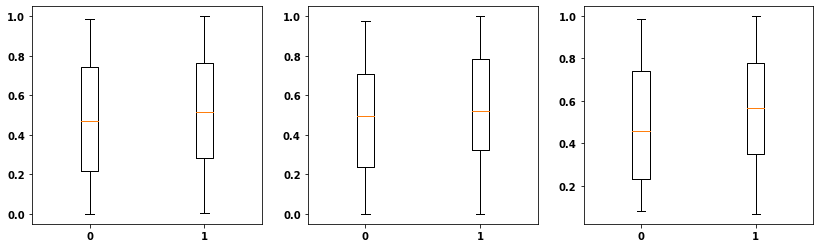

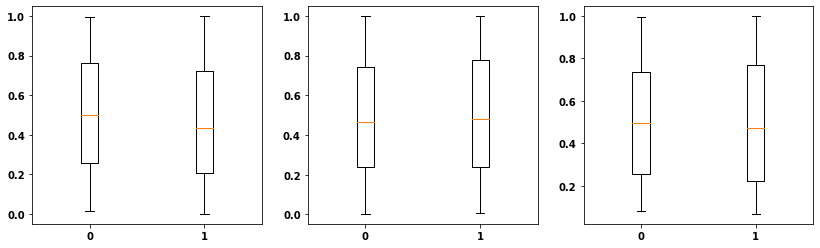

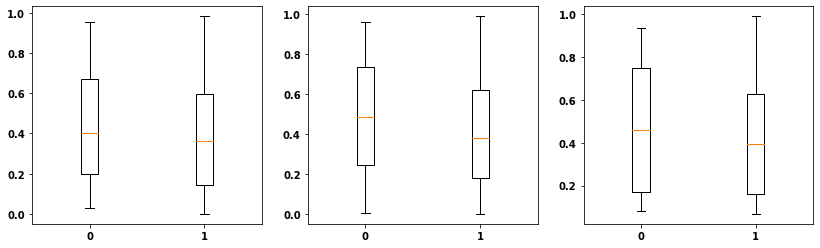

In [979]:
dbaseline, ebaseline = np.mean(baseline_degree_centrality,axis=0), np.mean(baseline_ev_percentile,axis=0)
dpresz, epresz       = np.mean(presz_degree_centrality,axis=0), np.mean(presz_ev_percentile,axis=0)

baseline_degree_p = data2percentile(dbaseline)
presz_degree_p    = data2percentile(dpresz)

baseline_e_p = data2percentile(ebaseline)
presz_e_p    = data2percentile(epresz)

baseline_raster_p = data2percentile(np.mean(baseline_raster, axis=0))
presz_raster_p    = data2percentile(np.mean(presz_raster, axis=0))

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].boxplot([baseline_degree_p[thalamus_idxs], presz_degree_p[thalamus_idxs]], positions=[0,1])
ax[1].boxplot([baseline_e_p[thalamus_idxs], presz_e_p[thalamus_idxs]], positions=[0,1])
ax[2].boxplot([baseline_raster_p[thalamus_idxs], presz_raster_p[thalamus_idxs]], positions=[0,1])
plt.show()

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].boxplot([baseline_degree_p[telen_idxs], presz_degree_p[telen_idxs]], positions=[0,1])
ax[1].boxplot([baseline_e_p[telen_idxs], presz_e_p[telen_idxs]], positions=[0,1])
ax[2].boxplot([baseline_raster_p[telen_idxs], presz_raster_p[telen_idxs]], positions=[0,1])
plt.show()

fig, ax = plt.subplots(1,3, figsize=(14,4))
ax[0].boxplot([baseline_degree_p[tectum_idxs], presz_degree_p[tectum_idxs]], positions=[0,1])
ax[1].boxplot([baseline_e_p[tectum_idxs], presz_e_p[tectum_idxs]], positions=[0,1])
ax[2].boxplot([baseline_raster_p[tectum_idxs], presz_raster_p[tectum_idxs]], positions=[0,1])
plt.show()

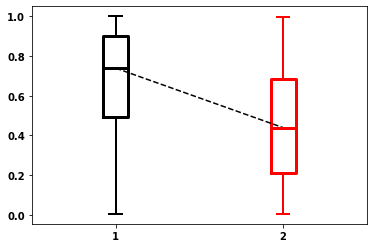

In [862]:
idxs = tectum_idxs

fig, ax = plt.subplots()
bplot = plt.boxplot([baseline_degree_p[idxs], presz_degree_p[idxs]], showfliers=False)
colors = ['k', 'r']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color(color)
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color(color)
    patch.set_linewidth(2)
    
plt.plot([1,2], [np.median(baseline_degree_p[idxs]), np.median(presz_degree_p[idxs])], color='k', linestyle='--')


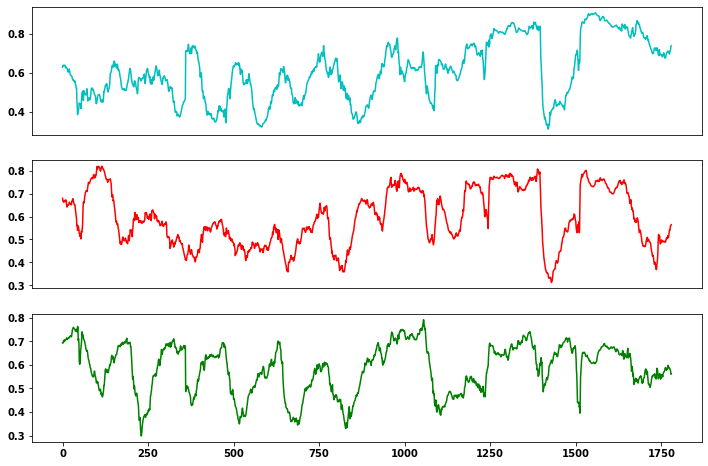

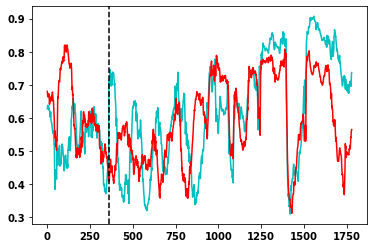

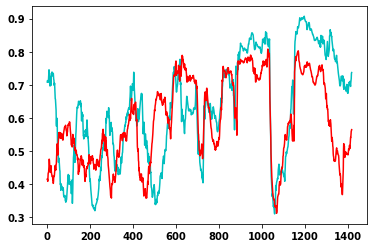

0.0717437840360847 0.7666409194160341 0.1743814128203321 2.7278226989827275e-140
-0.09462484842698773 0.29232712444741116 0.07294706867232326 1.1863802087358884e-15
-0.30104147350841104 0.3399513287028354 5.618519765556944e-09 6.173615450594816e-21


In [1434]:
raster = combined_raster
telen  = etel_jump_overlap
tectum = etect_jump_overlap
thalamus = eth_jump_overlap

%matplotlib inline
intelen, intectum, inthalamus, thubs = [], [], [], []

nbaseline, npresz = 0, 0
for t in range(combined_degree_centrality.shape[0]):
    #sl = raster[t,:]
    #arehubs = np.where(sl == 1)[0]
    if len(arehubs) == 0:
        print('fak')
        continue
        #intelen.append(intelen[-1]); intectum.append(intectum[-1]); inthalamus.append(inthalamus[-1])
    else:
#         intelen.append(len(set(telen) & set(arehubs)) / float(len(arehubs)))
#         intectum.append(len(set(tectum) & set(arehubs)) / float(len(arehubs)))      
#         inthalamus.append(len(set(thalamus)&set(arehubs)) / float(len(arehubs)))
#         thubs.append(intelen[-1] + intectum[-1] + inthalamus[-1])
        if t < baseline_raster.shape[0]: nbaseline += 1
        else: npresz += 1
        intelen.append(np.median(combined_ev_percentile[t,telen]))
        intectum.append(np.median(combined_ev_percentile[t,tectum]))
        inthalamus.append(np.median(combined_ev_percentile[t,thalamus]))
        
start = 0
fig, ax = plt.subplots(3,1,figsize=(12,8))
ax[0].plot(inthalamus[start:], color='c', label='thalamus')
ax[1].plot(intelen[start:], color='r', label='telen')
ax[2].plot(intectum[start:], color='g', label='tectum')         
# ax0 = ax[0].twinx()
# ax0.plot(np.arange(-120,traces.shape[1]-120-start), np.mean(traces[thalamus,:],axis=0)[start:], color='gray', alpha=0.5)
# ax1 = ax[1].twinx()
# ax1.plot(np.arange(-120,traces.shape[1]-120-start), np.mean(traces[telen,:],axis=0)[start:], color='gray', alpha=0.5)
# ax2 = ax[2].twinx()
# ax2.plot(np.arange(-120,traces.shape[1]-120-start), np.mean(traces[tectum,:],axis=0)[start:], color='gray', alpha=0.5)
ax[0].set_xticks([]); ax[1].set_xticks([])
plt.show()

plt.figure()
plt.plot(inthalamus[:], color='c')
plt.plot(intelen[:], color='r')
plt.axvline(len(baseline_degree_centrality), 0.0, 1.0, color='k', linestyle='--')
plt.show()

plt.figure()
plt.plot(inthalamus[len(baseline_degree_centrality):], color='c')
plt.plot(intelen[len(baseline_degree_centrality):], color='r')
plt.show()


from scipy.stats import pearsonr
backup = len(baseline_degree_centrality)
frontskip = 0

before_corr, bp = pearsonr(intelen[frontskip:len(baseline_degree_centrality)], inthalamus[frontskip:len(baseline_degree_centrality)])
after_corr, ap = pearsonr(intelen[len(presz_degree_centrality)-backup:], inthalamus[len(presz_degree_centrality)-backup:])
print(before_corr, after_corr, bp, ap)

before_corr, bp = pearsonr(intectum[frontskip:len(baseline_degree_centrality)], inthalamus[frontskip:len(baseline_degree_centrality)])
after_corr, ap  = pearsonr(intectum[len(presz_degree_centrality)-backup:], inthalamus[len(presz_degree_centrality)-backup:])
print(before_corr, after_corr, bp, ap)

before_corr, bp = pearsonr(intectum[frontskip:len(baseline_degree_centrality)], intelen[frontskip:len(baseline_degree_centrality)])
after_corr, ap  = pearsonr(intectum[len(presz_degree_centrality)-backup:], intelen[len(presz_degree_centrality)-backup:])
print(before_corr, after_corr, bp, ap)


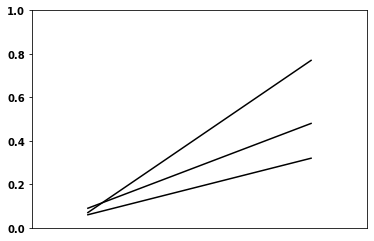

0.03739987812027181


In [1412]:
baseline = [0.06, 0.09, 0.07]
presz    = [0.32, 0.48, 0.77]

plt.figure()
for i in range(3):
    plt.plot([0,1], [baseline[i], presz[i]], color='k')
plt.xlim([-0.25, 1.25])
plt.ylim([0., 1.])
plt.xticks([])
plt.show()

_, p = wilcoxon(baseline, presz, alternative='less', correction=False, zero_method='pratt')
_, p = ttest_rel(baseline, presz)
print(p/2.)

0.247 -0.03
0.02915605793814422


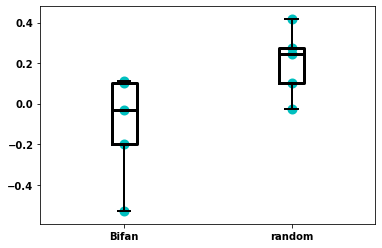

In [1445]:
#edge swap

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from scipy.stats import ranksums
from scipy.stats import wilcoxon

random_edge = [0.1, 0.247, -0.027, 0.273, 0.417]
bifan_edge  = [0.1, -0.53, -0.2, 0.11, -0.03]

plt.figure()
bplot = plt.boxplot([bifan_edge, random_edge], showfliers=False)
plt.xticks([1, 2], ['Bifan', 'random'])
plt.scatter([1 for _ in range(len(bifan_edge))], bifan_edge, color='c', linewidth=4)
plt.scatter([2 for _ in range(len(random_edge))], random_edge, color='c', linewidth=4)
print(np.median(random_edge), np.median(bifan_edge))
_, p = ttest_ind(random_edge, bifan_edge)
print(p/2.)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_color('k')
    patch.set_linewidth(3)
for patch, color in zip(bplot['medians'], colors):
    patch.set_color('k')
    patch.set_linewidth(3)
    
colors = ['k', 'k', 'r', 'r']
for patch, color in zip(bplot['whiskers'], colors):
    patch.set_color('k')
    patch.set_linewidth(2)
    
for patch, color in zip(bplot['caps'], colors):
    patch.set_color('k')
    patch.set_linewidth(2)
